# Can we predict hyper-reactive cysteines in proteins towards IAA? 

### 1. Experimental isoTOP-ABPP data has been gathered from two previously published datasets (Weerapana 2020 & Palafox 2019) and thirteen new isoTOP-ABPP experiments performed in 2023.
### 2. Cysteines identified in at least 2/26 experiments and cysteines with ratios that had a standard deviation of < 3 were kept for processing.
### 3. Cysteines with ratios between 0.5 - 2.3 are considered as displaying "hyper-reactivity" towards iodoacetamide alkyne. The classification for hyper-reactive cysteines towards IAA = 1. The classification for low-reactive cysteines towards IAA = 0.
### 4. Proteins identified in these experiments were cross-referenced with PDB structures. Structures with mutations, modifications and those that did not contain the associated identified cysteine were discarded.
### 5. Descriptors were calculated using , DSSP, Fpocket, propKa v3.1, as well as in house calculated descriptors of amino acid content (AAC) and hydrogen bond donor and acceptors.
### 6. Ablation studies determined a subset of features (over recursive feature elimination using all features) provides the highest TPR for chosen test set, including AAC, hydrogen bond donor and acceptors, and relative solvent accessibility (RSA).

# 

### Test Sets: Compiled Five Studies from Previous Literature

#### Weerapana et al. 2017, Cravatt et al. 2019,  Hacker et al. 2020, Wang et al. 2022, and Backus et al. 2024.

# 

## Import Modules

In [1]:
from datetime import date
import os, sys, random, pickle

# Data Processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import shap

# Modelling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, matthews_corrcoef, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn import metrics

## Define Functions

In [4]:
def get_class_balance_barplot(bar_df, save):
    bar_df['uniprot_identifier'] = bar_df['identifier'].map(lambda x: str(x).split("_")[0] + '_' + str(x).split("_")[1])
    df_0 = bar_df[bar_df['reactivity'] == 0]
    df_0_ids = list(df_0['uniprot_identifier'].unique())
    df_1 = bar_df[bar_df['reactivity'] == 1]
    df_1_ids = list(df_1['uniprot_identifier'].unique())
    target_cid_df = pd.DataFrame()
    target_cid_df['reactivity'] = ['Low', 'High']
    target_cid_df['count'] = [len(df_0_ids), len(df_1_ids)]
    print(target_cid_df)
    if save == True:
        sns.barplot(data=target_cid_df, x="reactivity", y="count")
        
    return target_cid_df

In [6]:
def get_class_balance_barplot_test(bar_df, save):
    bar_df['uniprot_identifier'] = bar_df['identifier'].map(lambda x: str(x).split("_")[0] + '_' + str(x).split("_")[1])
    df_0 = bar_df[bar_df['reactivity'] == 'Low']
    df_0_ids = list(df_0['uniprot_identifier'].unique())
    df_1 = bar_df[bar_df['reactivity'] == 'High']
    df_1_ids = list(df_1['uniprot_identifier'].unique())
    target_cid_df = pd.DataFrame()
    target_cid_df['reactivity'] = ['Low', 'High']
    target_cid_df['count'] = [len(df_0_ids), len(df_1_ids)]
    print(target_cid_df)
    if save == True:
        sns.barplot(data=target_cid_df, x="reactivity", y="count")
        
    return target_cid_df

In [8]:
def get_stats(y_test_vals, y_pred_vals):
    acc = round(accuracy_score(y_test_vals, y_pred_vals)*100, 2)
    prec = round(precision_score(y_test_vals, y_pred_vals)*100, 2)
    recall = round(recall_score(y_test_vals, y_pred_vals)*100, 2)
    
    fp, tp, th = roc_curve(y_test_vals, y_pred_vals)
    tpr = round(tp[1]*100, 2)
    fpr = round(fp[1]*100, 2)
    
    recall_sensitivity = round(metrics.recall_score(y_test_vals, y_pred_vals, pos_label=1)*100, 2)
    recall_specificity = round(metrics.recall_score(y_test_vals, y_pred_vals, pos_label=0)*100, 2)
    f1 = round(f1_score(y_test_vals, y_pred_vals)*100, 2)
    
    auc_val = round(auc(fp, tp)*100, 2)
    mcc_val = round(matthews_corrcoef(y_test_vals, y_pred_vals)*100, 2)
    
    score_names = ['Accuracy', 'Precision', 'Recall', 'TPR', 'FPR', 'Sensitivity' , 'Specificity', 'F1', 'AUC', 'MCC']
    score_vals = [acc, prec, recall, tpr, fpr, recall_sensitivity, recall_specificity, f1, auc_val, mcc_val]

    # Create a dictionary with column names as keys and values as values
    data_dict = {name: value for name, value in zip(score_names, score_vals)}

    # Create a DataFrame from the dictionary
    stat_df = pd.DataFrame(data=data_dict, index=[0])
    
    return stat_df

In [10]:
def get_identifier_df(df):
    tmp_df = df[['identifier', 'ratio_mean']]
    identifier_df = tmp_df.copy()
    identifier_df['index'] = tmp_df.index
    ml_df = df.drop(columns = ['identifier', 'ratio_mean'])
    
    return identifier_df, ml_df

In [12]:
def get_result_csv(identifier_df, X_test_df, y_test, clf_predict, title, save):
    X_test_df['index'] = X_test_df.index
    X_new = pd.merge(X_test_df, identifier_df, on = 'index', how = 'left')
    results_df = X_new.copy()
    results_df['y_actual'] = list(y_test)
    results_df['y_predicted'] = clf_predict
    results_df['correct'] = np.where(results_df['y_actual'] == results_df['y_predicted'], 1, 0)
    
    if save == True:
        results_df.to_csv(title + '.csv')

    return results_df

In [14]:
def plot_cm_stats(i, name, y_test_vals, y_pred_vals, save):
    
    fp, tp, th = roc_curve(y_test_vals, y_pred_vals)
    tpr = round(tp[1]*100, 2)
    fpr = round(fp[1]*100, 2)
    
    recall_sensitivity = round(metrics.recall_score(y_test_vals, y_pred_vals, pos_label=1)*100, 2)
    recall_specificity = round(metrics.recall_score(y_test_vals, y_pred_vals, pos_label=0)*100, 2)
    
    fnr = round(100 - recall_sensitivity, 2)
    
    cm = confusion_matrix(y_test_vals, y_pred_vals)
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Low', 'High'])
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    
    manual_percentages = [recall_specificity, fpr, fnr, tpr]
    group_percentages = [f"{value}%" for value in manual_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    print(group_percentages)
    
    ax = plt.subplot()
    plt.rcParams.update({'font.size': 15})

    sns.heatmap(cm, annot=False, fmt='', cmap='Blues')

    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit
    ax.set_xlabel('Predicted Reactivity', fontdict=label_font);
    ax.set_ylabel('Observed Reactivity', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Low', 'High']);
    ax.yaxis.set_ticklabels(['Low', 'High']);

    if save == True:
        plt.savefig(str(date) + '_' + name + '_percent_stats_confusion_matrix.png', bbox_inches = 'tight', dpi = 300)
#     plt.show()

In [16]:
def plot_cm_function_stats(i, name, y_test_vals, y_pred_vals, save):
    
    fp, tp, th = roc_curve(y_test_vals, y_pred_vals)
    tpr = round(tp[1]*100, 2)
    fpr = round(fp[1]*100, 2)
    
    recall_sensitivity = round(metrics.recall_score(y_test_vals, y_pred_vals, pos_label=1)*100, 2)
    recall_specificity = round(metrics.recall_score(y_test_vals, y_pred_vals, pos_label=0)*100, 2)
    
    fnr = round(100 - recall_sensitivity, 2)
    
    cm = confusion_matrix(y_test_vals, y_pred_vals)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Low', 'High'])

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    
    manual_percentages = [recall_specificity, fpr, fnr, tpr]
    group_percentages = [f"{value}%" for value in manual_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    print(group_percentages)
    
    plt.rcParams.update({'font.size': 15})

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_vals, y_pred_vals), display_labels = ['Low', 'High']).plot(cmap = 'Blues')
    
    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit

    title_font = {'size':'20'}  # Adjust to fit
    # ax.set_title(name.replace('_', ' ') + '\n' + 'Confusion Matrix', fontdict=title_font);

    plt.xlabel('Predicted Reactivity', size = 20)
    plt.ylabel('Observed Reactivity', size = 20)
    # plt.title(name.replace('_', ' ') + '\n' + 'Confusion Matrix', size = 20)
    plt.title('Confusion Matrix', size = 20)

    if save == True:
        plt.savefig(str(date) + '_' + name + '_raw_stats_confusion_matrix.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

In [18]:
def plot_cm_raw(i, name, y_test, y_test_predict, save):
    
    cm = confusion_matrix(y_test, y_test_predict)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Low', 'High'])
    
    ax = plt.subplot()
    plt.rcParams.update({'font.size': 15})
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'20'}  # Adjust to fit
    ax.set_xlabel('Predicted Reactivity', fontdict=label_font);
    ax.set_ylabel('Observed Reactivity', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Low', 'High']);
    ax.yaxis.set_ticklabels(['Low', 'High']);

    if save == True:
        plt.savefig(str(date) + '_' + name + '_raw_confusion_matrix.png', bbox_inches = 'tight', dpi = 300)

In [20]:
def get_horizontal_feature_importances(X, rfc, name, rfe, save):
    if rfe == True:
        feat_coeff = pd.DataFrame({'features': rfc['Feature'],'impacts': rfc['Importance']})
    else:
        feat_coeff = pd.DataFrame({'features': X.columns,'impacts': rfc.feature_importances_})
    feat_coeff = feat_coeff.sort_values('impacts', ascending=False)
    fig, ax1 = plt.subplots(1,1, figsize=(8, 12));
    sns.set_style("white")
    sns.barplot(y=feat_coeff.features, x=feat_coeff.impacts, ax=ax1, orient = "h", palette = 'Blues_r');
    ax1.set_title('Random Forest Feature Importances', size = 20);
    ax1.set_xlabel('Impact', size = 20);
    ax1.set_ylabel('Feature', size=20);
    plt.xticks(size =20)
    plt.yticks(size = 20)
    
    if save == True:
        plt.savefig(date + '_' + name + '_feature_importances_horizontal.png', dpi = 300, bbox_inches = 'tight') 
    plt.show()

In [22]:
def get_shap_plot(X_test, rfc, name, save):
    
    ax = plt.subplot()
    plt.rcParams.update({'font.size': 15})
    
    explainer = shap.TreeExplainer(rfc)
    
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values[:,:,1], X_test.values, feature_names = X_test.columns, show = False)

    ax.set_title('Random Forest SHAP Summary', size = 20);
        
    ax.set_xlabel('SHAP value', size=20);
    ax.set_ylabel('Feature', size=20);
    
    plt.xticks(size = 20, rotation = 45)
    plt.yticks(size = 20)
    
    if save == True:
        plt.savefig(date + '_' + name + '_shap_plot.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

In [24]:
def plot_roc_curve(fprs, tprs, name, save):

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(10, 8))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        print(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax.set_xlabel('False Positive Rate', size = 20)
    ax.set_ylabel('True Positive Rate', size = 20)
    ax.set_title('Receiver Operating Characteristic', size = 20)
    ax.legend(loc="lower right", fontsize = 15)
    
    if save == True:
        plt.savefig(date + '_' + name + '_roc_auc_cv_5.png', dpi=300, bbox_inches='tight')
    plt.show()
    return (f, ax)

def compute_roc_auc(index, clf):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [26]:
def get_5_cv_balanced_roc_curve(name, ml_df, X_vals, y_vals, save):

    clf = RandomForestClassifier(random_state = 42)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []
    
    for i in range(5):
        identifier_df, training_set, test_set, current_ml_training_set, ml_test_set = random_sample(ml_df)
        
        # get X and y values
        current_X_train = current_ml_training_set.drop('reactivity', axis = 1)
        current_y_train = current_ml_training_set['reactivity']

        # get X and y values
        current_X_test = current_ml_test_set.drop('reactivity', axis = 1)
        current_y_test = current_ml_test_set['reactivity']

        clf.fit(current_X_train, current_y_train)
        _, _, auc_score_train = compute_roc_auc(current_ml_training_set, clf)
        fpr, tpr, auc_score = compute_roc_auc(current_ml_test_set, clf)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs, name, save)
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [28]:
def get_rfe_plot(rfecv, name, save):
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(10, 8))
    plt.xlabel("Number of Features Selected", size = 20)
    plt.ylabel("Mean Test Accuracy", size = 20)
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    # plt.title("Recursive Feature Elimination \nwith correlated features", fontsize = 20)
    plt.title("Recursive Feature Elimination", fontsize = 20)
    
    if save == True:
        plt.savefig(date + '_' + name + '_recursive_feature_elimination.png', dpi = 300, bbox_inches = 'tight') 
    plt.show()

In [30]:
def get_rfe_df(rfecv, X):
    rfe_features_df = pd.DataFrame()
    rfe_features_df['Feature'] = X.columns
    rfe_features_df['Support'] = rfecv.support_
    rfe_features_df['Ranking'] = rfecv.ranking_
    
    chosen_rfe_features_df = rfe_features_df[rfe_features_df['Support'] == True]
    chosen_rfe_features_df['Importance'] = rfecv.estimator_.feature_importances_ 
    chosen_ids = list(chosen_rfe_features_df['Feature'])
    
    not_chosen_rfe_features_df = rfe_features_df[rfe_features_df['Support'] == False]
    not_chosen_ids = list(not_chosen_rfe_features_df['Feature'])
    
    return rfe_features_df, chosen_rfe_features_df, chosen_ids, not_chosen_ids

# 

## Define Environment

In [36]:
cd = os.getcwd()

In [38]:
date = 'ciaa'

In [40]:
save = False

In [42]:
# create a new directory for results
results_dir = date + '_results'
os.mkdir(results_dir)
os.chdir(results_dir)

# 

# Read Training Set

In [32]:
df = pd.read_csv('../../data/isotop_training_set.csv')
df.shape

(1370, 32)

In [33]:
df

,identifier,ratio_mean,CYS_P_7.5,ASP_P_7.5,SER_P_7.5,GLN_P_7.5,LYS_P_7.5,ILE_P_7.5,PRO_P_7.5,THR_P_7.5,...,hbond_don_sc_atom_5_P,hbond_acc_sc_atom_5_P,hbond_don_bb_atom_5_P,hbond_acc_bb_atom_5_P,hbond_don_sc_atom_5_7.5_P,hbond_acc_sc_atom_5_7.5_P,hbond_don_bb_atom_5_7.5_P,hbond_acc_bb_atom_5_7.5_P,saas_P_7.5,reactivity
0,A0AVT1_C347_7PYV_C347,1.724610,0.000000,8.333333,16.666667,16.666667,0.000000,0.000000,8.333333,0.000000,...,0.000000,3.409091,3.409091,0.000000,6.818182,3.409091,4.545455,6.818182,28.888889,1
1,O00139_C199_2GRY_C172,12.674860,0.000000,14.285714,0.000000,0.000000,0.000000,28.571429,0.000000,0.000000,...,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,10.000000,4.000000,57.037037,0
2,O00151_C260_1X62_C18,12.107111,10.526316,5.263158,0.000000,0.000000,5.263158,10.526316,10.526316,5.263158,...,1.886792,1.257862,1.886792,0.628931,3.144654,2.515723,2.515723,6.289308,1.481481,0
3,O00151_C307_1X62_C65,11.238239,10.526316,5.263158,0.000000,0.000000,10.526316,5.263158,0.000000,10.526316,...,2.027027,2.027027,2.027027,0.000000,2.027027,2.702703,6.081081,5.405405,5.185185,0
4,O00170_C90_2LKN_C90,13.624860,0.000000,5.555556,0.000000,5.555556,5.555556,16.666667,5.555556,5.555556,...,0.000000,0.000000,0.581395,1.744186,1.162791,1.162791,5.813953,2.325581,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,Q9Y5P4_C65_5JJD_C65,15.762267,0.000000,0.000000,14.285714,0.000000,0.000000,7.142857,0.000000,7.142857,...,2.884615,2.884615,1.923077,0.961538,0.961538,0.000000,3.846154,5.769231,47.407407,0
1366,Q9Y678_C706_1R4X_C706,1.511846,4.545455,4.545455,0.000000,9.090909,4.545455,4.545455,4.545455,13.636364,...,0.555556,0.555556,2.777778,2.222222,1.111111,1.111111,4.444444,5.000000,0.000000,1
1367,Q9Y679_C391_2EKF_C41,2.055877,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,...,0.000000,0.000000,1.562500,0.000000,1.562500,3.125000,6.250000,3.125000,48.148148,1
1368,Q9Y696_C35_2AHE_C35,1.720962,0.000000,0.000000,6.666667,6.666667,6.666667,6.666667,20.000000,0.000000,...,0.775194,0.775194,1.550388,1.550388,1.550388,0.000000,3.100775,4.651163,13.333333,1


## Check there are no missing values

In [35]:
df.columns[df.isnull().any()]

Index([], dtype='object')

## Check if reactivity classes are balanced

In [37]:
# by unique cysteineids
get_class_balance_barplot(df, False)

  reactivity  count
0        Low    286
1       High    292


,reactivity,count
0,Low,286
1,High,292


reactivity
0    694
1    676
Name: count, dtype: int64

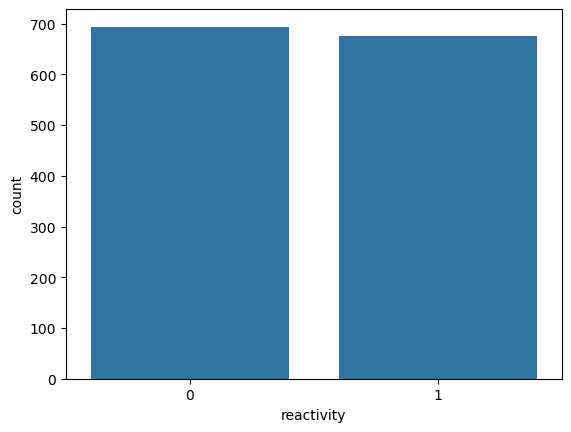

In [38]:
# by unique rowids
sns.countplot(x=df['reactivity'])
df['reactivity'].value_counts()

# Exploratory Data Analysis (EDA)

### Are any indiviudal descriptors enough to predict IAA cysteine reactivity? 

In [41]:
heatmap_df = df.copy()
heatmap_df = heatmap_df.drop(columns = ['identifier', 'reactivity', 'uniprot_identifier'])
corr_df = heatmap_df.corr()
corr_df.to_csv(date + '_correlation_heatmap.csv')

<Axes: >

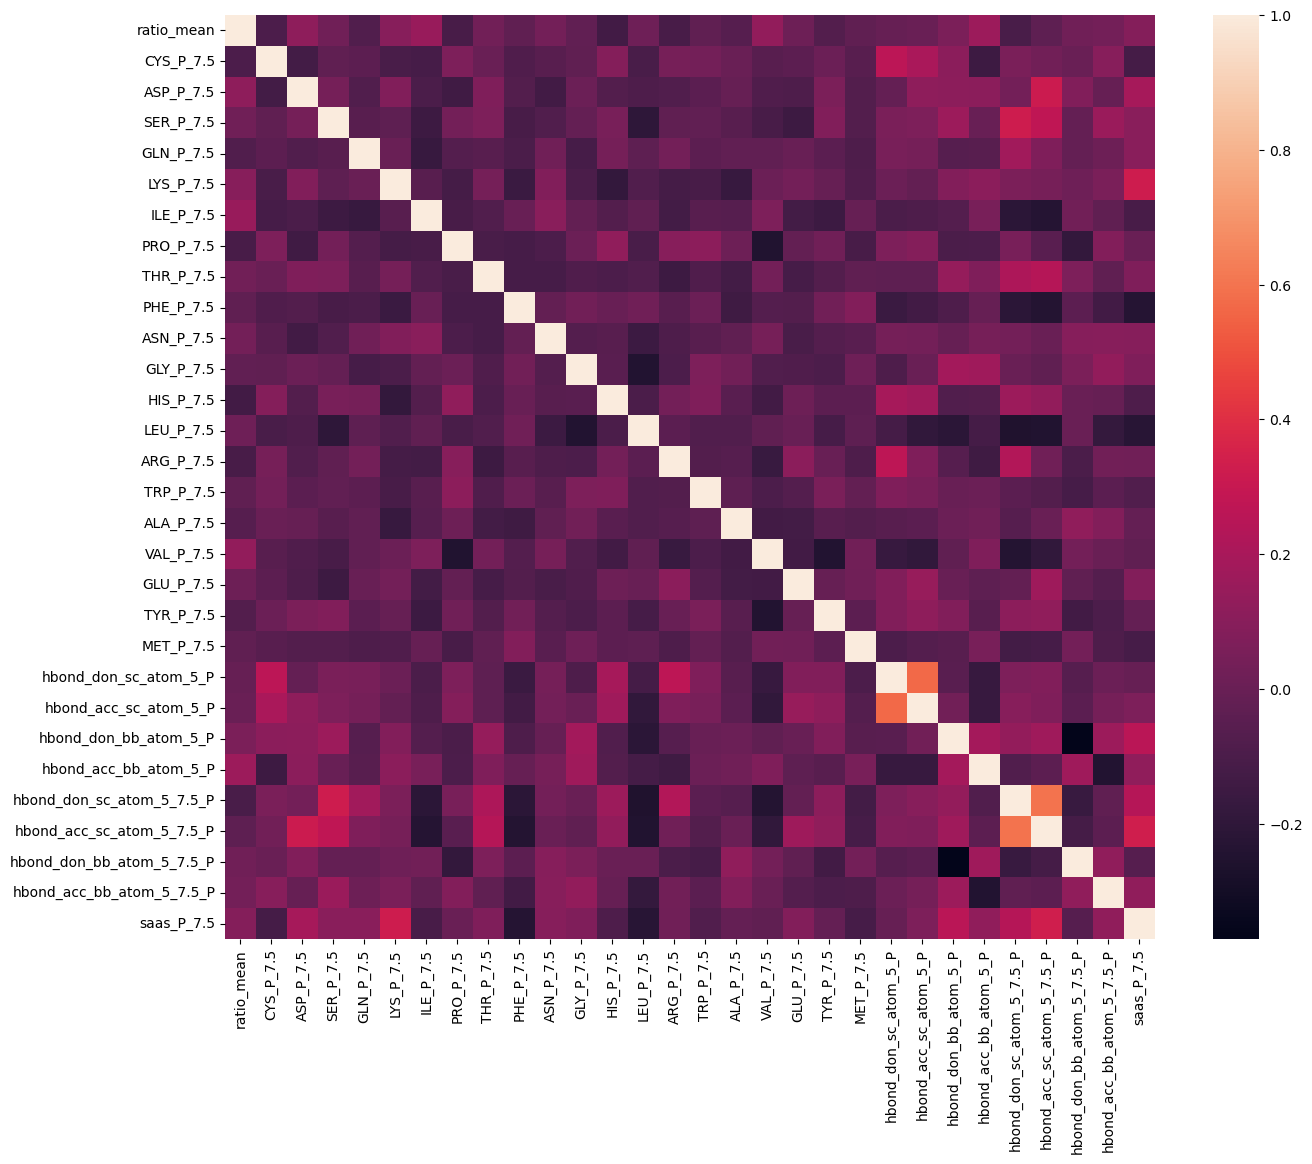

In [42]:
plt.figure(figsize = (15, 12))
sns.heatmap(corr_df, fmt = '.1g', annot = False)

### No. The strongest positive correlation between experimentally determined isoTOP ratios and each descriptor is 0.16 for the percentage of hydrogen bond acceptor backbone atoms within 5 Angstroms of a reactive SG atom (hbond_acc_bb_atom_5_P). The strongest negative correlation between experimentally determined isoTOP ratios and each descriptor is -0.11 for the percentage of hydrogen bond donor side chain atoms within 5 - 7.5 Angstroms of a reactive SG atom (hbond_don_sc_atom_5_7.5_P). However, these are relatively weak correlations. 

# 

# Read Test File

In [46]:
validation_df = pd.read_csv('../../data/isotop_test_set.csv')

In [47]:
validation_df 

,identifier,ratio_mean,CYS_P_7.5,ASP_P_7.5,SER_P_7.5,GLN_P_7.5,LYS_P_7.5,ILE_P_7.5,PRO_P_7.5,THR_P_7.5,...,hbond_don_sc_atom_5_P,hbond_acc_sc_atom_5_P,hbond_don_bb_atom_5_P,hbond_acc_bb_atom_5_P,hbond_don_sc_atom_5_7.5_P,hbond_acc_sc_atom_5_7.5_P,hbond_don_bb_atom_5_7.5_P,hbond_acc_bb_atom_5_7.5_P,saas_P_7.5,reactivity
0,O00255_C414_4OG4_C409,10.017634,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,...,0.000000,1.333333,2.000000,2.666667,2.666667,2.000000,6.666667,2.666667,0.000000,0
1,O00255_C414_6BXH_C409,10.017634,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,...,0.000000,0.645161,1.290323,1.290323,1.935484,2.580645,7.096774,4.516129,0.000000,0
2,O00255_C414_6O5I_C409,10.017634,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,...,1.290323,1.290323,1.290323,2.580645,1.935484,3.225806,7.741935,2.580645,0.000000,0
3,O00255_C414_6S2K_C411,10.017634,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,...,1.250000,0.625000,1.250000,2.500000,1.875000,1.875000,7.500000,2.500000,0.000000,0
4,O00255_C414_6WNH_C409,10.017634,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,...,0.000000,0.636943,1.273885,1.910828,2.547771,3.184713,7.006369,3.821656,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,Q9Y6M9_C31_5XTC_C31,15.000000,0.0,0.000000,5.555556,5.555556,16.666667,0.000000,0.000000,0.0,...,0.000000,0.000000,1.190476,1.190476,1.785714,0.000000,6.547619,5.357143,2.222222,0
591,Q9Y6N5_C127_6MO6_C127,15.400000,0.0,7.692308,7.692308,0.000000,15.384615,15.384615,7.692308,0.0,...,0.694444,1.388889,1.388889,2.777778,3.472222,2.777778,5.555556,2.777778,14.074074,0
592,Q9Y6N5_C127_6MP5_C127,15.400000,0.0,0.000000,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,...,2.127660,0.709220,1.418440,2.127660,1.418440,2.836879,4.964539,3.546099,0.740741,0
593,Q9Y6N5_C127_6OIB_C127,15.400000,0.0,7.142857,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,...,1.438849,0.000000,1.438849,3.597122,2.877698,4.316547,5.755396,2.877698,0.740741,0


## Check there are no missing values 

In [49]:
validation_df.columns[validation_df.isnull().any()]

Index([], dtype='object')

## Check if reactivity classes are balanced 

In [51]:
# by unique cysteineids
get_class_balance_barplot(validation_df, False)

  reactivity  count
0        Low    129
1       High    138


,reactivity,count
0,Low,129
1,High,138


reactivity
0    310
1    285
Name: count, dtype: int64

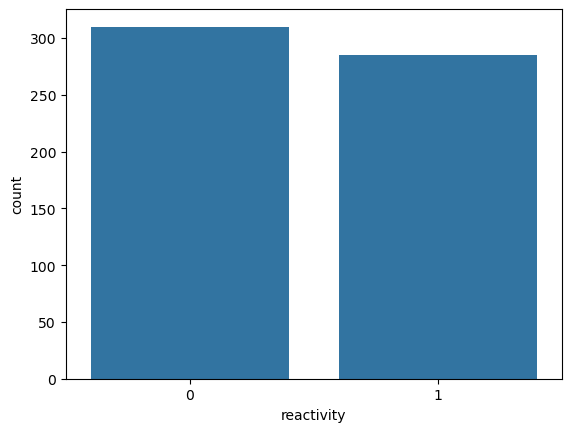

In [52]:
# by unique rowids
sns.countplot(x=validation_df['reactivity'])
validation_df['reactivity'].value_counts()

# 

# Train, Test, Split 

In [55]:
ml_df = df.drop(columns = ['uniprot_identifier'])
df.shape, ml_df.shape

((1370, 33), (1370, 32))

In [56]:
# track ids for identifying false +/- cases
identifier_df, ml_df = get_identifier_df(ml_df)

In [57]:
# get X and y values
X_train = ml_df.drop(['reactivity'], axis = 1)
y_train = ml_df['reactivity']

In [58]:
# track input features
features = X_train.columns.to_list()

In [59]:
# track ids for identifying false +/- cases
validation_identifier_df, validation_ml_df = get_identifier_df(validation_df)

In [60]:
# get X and y values
validation_X = validation_ml_df.drop('reactivity', axis = 1)
validation_X = validation_X.drop(columns = ['uniprot_identifier'])
validation_y = validation_ml_df['reactivity']

In [61]:
X_train.shape, y_train.shape, validation_X.shape, validation_y.shape

((1370, 29), (1370,), (595, 29), (595,))

# 

# Model Building

## Algorithm Comparison

In [65]:
# import sklearn modules
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [66]:
# list of Machine Learning methods
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

In [67]:
def compare_algorithms_boxplot(score, score_name, ml_df, validation_ml_df):
    
    # compare algorithms
    results = []
    names = []
    iterations = []
    scoring = score
    
    for name, model in models:
        for i in range(5):
            
            df_train_percent = ml_df.sample(frac=0.8)

            # get X and y values
            current_X_train = df_train_percent.drop(['reactivity'], axis = 1)
            current_y_train = df_train_percent['reactivity']

            df_test_percent = validation_ml_df.sample(frac=0.8)

            # get X and y values
            current_X_test = df_test_percent.drop('reactivity', axis = 1)
            current_y_test = df_test_percent['reactivity']

            model.fit(current_X_train, current_y_train)
            y_predict = model.predict(current_X_test)
            
            if  score_name == 'Accuracy':
                acc = round(accuracy_score(current_y_test, y_predict)*100, 2)
                results.append(acc)
            else:
                fp, tp, th = roc_curve(current_y_test, y_predict)
                tpr = round(tp[1]*100, 2)
                fpr = round(fp[1]*100, 2)
                auc_val = round(auc(fp, tp)*100, 2)
                results.append(auc_val)
            names.append(name)
            iterations.append(i+1)
            
    results_df = pd.DataFrame()
    results_df['model'] = names
    results_df['score'] = results
    results_df['fold'] = iterations
    
    results_df.sort_values(by = ['score'], ascending = False, inplace = True)    

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    sns.boxplot(data = results_df, x = 'model', y = 'score', palette="Blues_r")
    # sns.boxplot(data = results_df, x = 'model', y = 'score')
    ax.set_title('Comparison between Different ML Algorithms', size = 20)
    plt.ylim(40, 80)
    plt.xlabel('Algorithm', size = 20)
    plt.ylabel(score_name, size = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.savefig(date + '_algorithm_comparison_' + score + '.png', dpi = 300, bbox_inches = 'tight') 
    plt.show()
    
    return results_df

In [68]:
lof_train_df = X_train.copy()
lof_train_df['reactivity'] = y_train

In [69]:
lof_test_df = validation_X.copy()
lof_test_df['reactivity'] = validation_y

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/3826879517.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = results_df, x = 'model', y = 'score', palette="Blues_r")


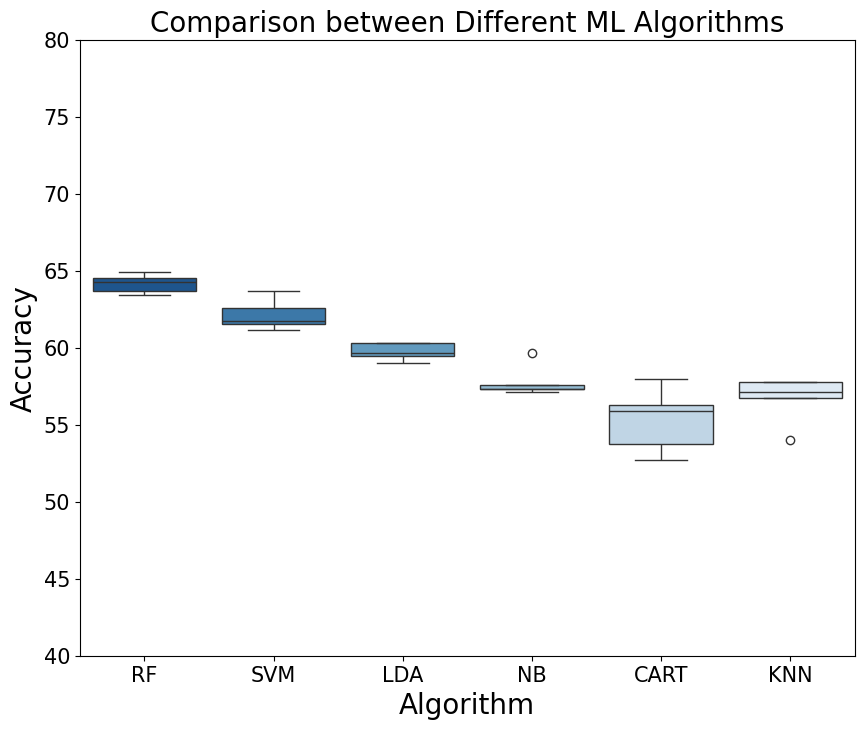

In [70]:
acc_results_df = compare_algorithms_boxplot('accuracy', 'Accuracy', lof_train_df, lof_test_df)

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/3826879517.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = results_df, x = 'model', y = 'score', palette="Blues_r")


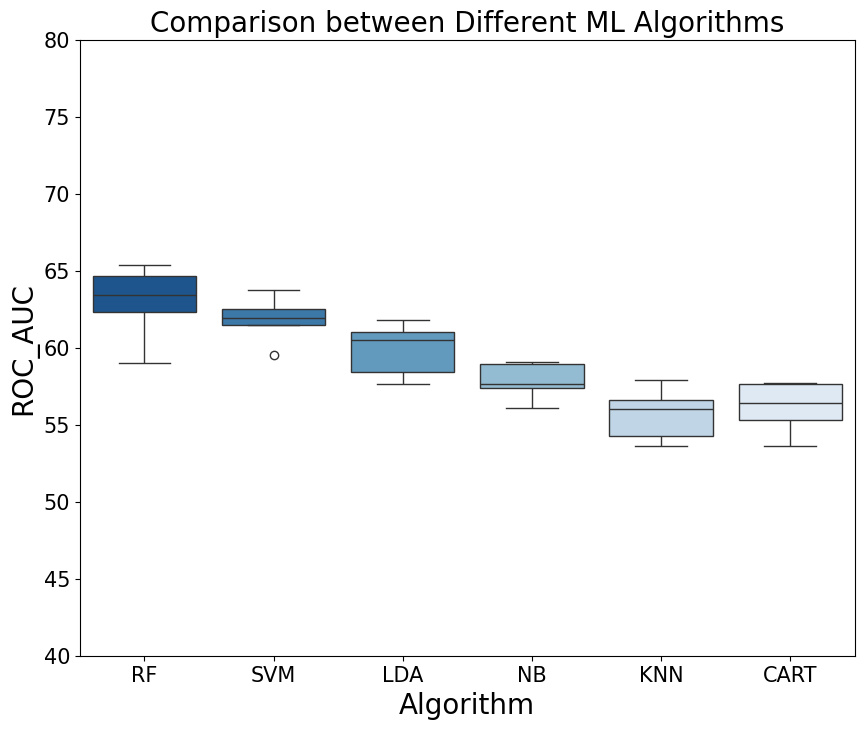

In [71]:
roc_results_df = compare_algorithms_boxplot('roc_auc', 'ROC_AUC', lof_train_df, lof_test_df)

## Advanced MLA Comparison

In [73]:
# Application of all Machine Learning methods
MLA = [
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
  
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    ]

In [74]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:  
    
    predicted = alg.fit(X_train, y_train).predict(validation_X)
    fp, tp, th = roc_curve(validation_y, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(validation_X, validation_y), 4)
    MLA_compare.loc[row_index, 'Precision'] = precision_score(validation_y, predicted)
    MLA_compare.loc[row_index, 'Recall'] = recall_score(validation_y, predicted)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

    row_index+=1

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [75]:
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/475705535.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MLA used", y="Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))


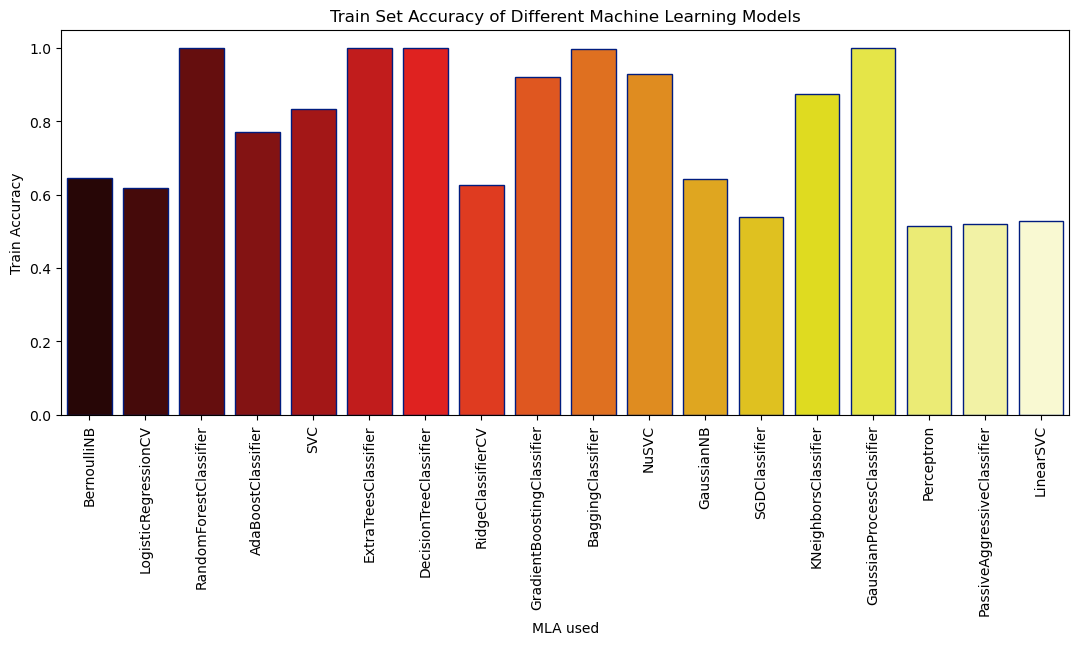

In [76]:
# Creating plot to show the train accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Train Set Accuracy of Different Machine Learning Models')
plt.savefig(date + '_algorithm_comparison_extra_train_accuracy.png', dpi = 300, bbox_inches = 'tight') 
plt.show()

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/624450112.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MLA used", y="Test Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))


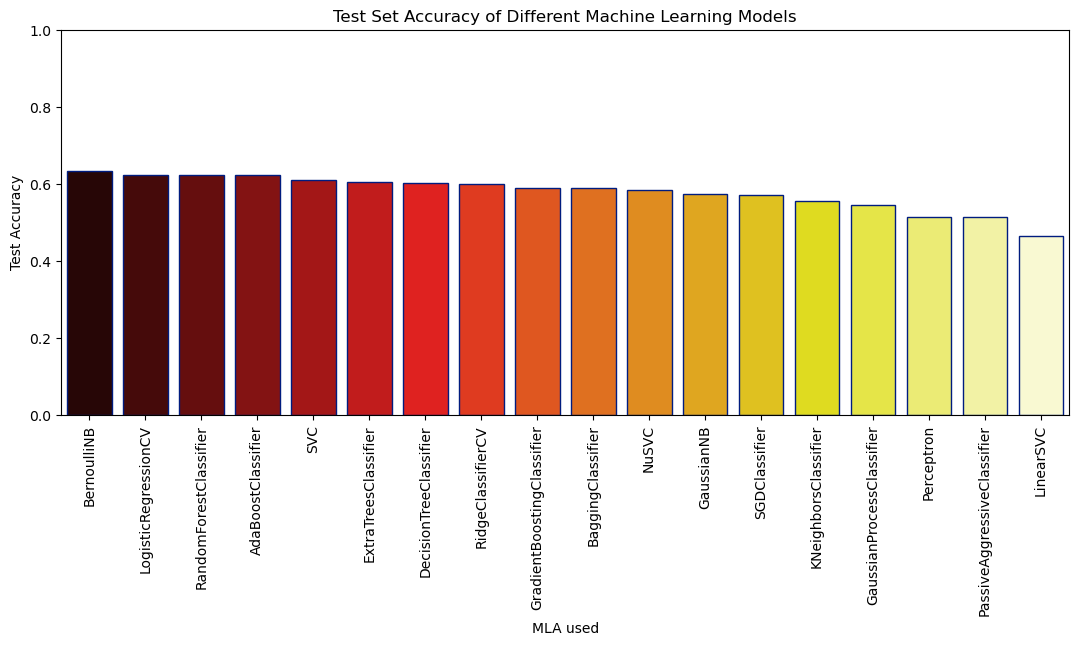

In [77]:
# Creating plot to show the test accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Test Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title('Test Set Accuracy of Different Machine Learning Models')
plt.savefig(date + '_algorithm_comparison_extra_test_accuracy.png', dpi = 300, bbox_inches = 'tight') 
plt.show()

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/3556012283.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MLA used", y="Precision",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))


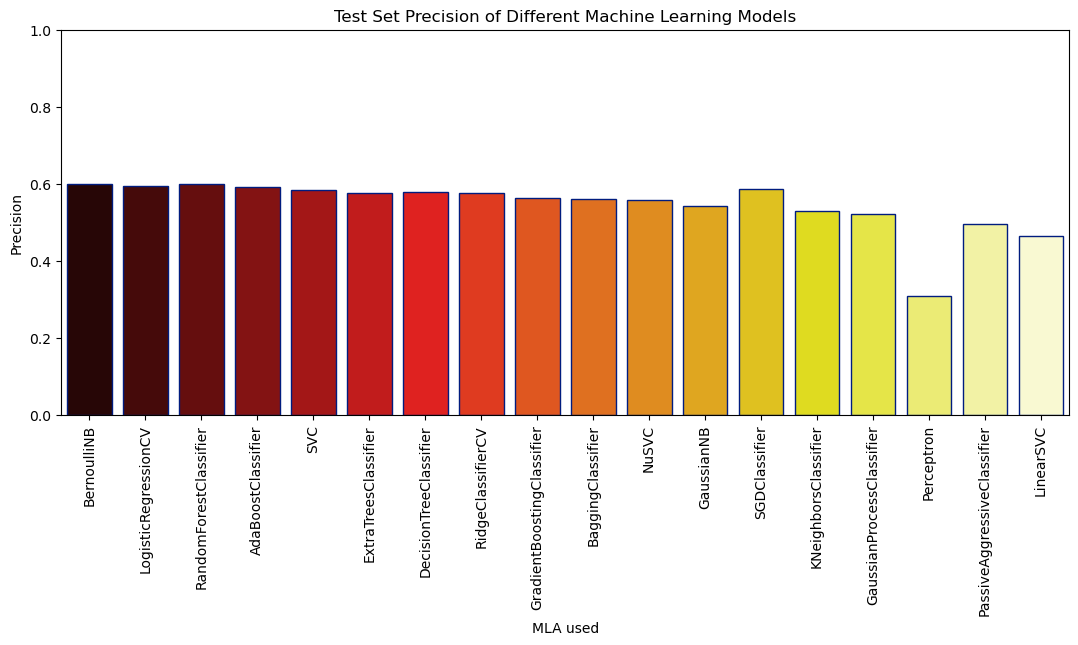

In [78]:
# Creating plots to compare precission of the MLAs
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Precision",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90) 
plt.ylim(0, 1)
plt.title('Test Set Precision of Different Machine Learning Models')
plt.savefig(date + '_algorithm_comparison_extra_precision.png', dpi = 300, bbox_inches = 'tight') 
plt.show()

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/3970755292.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MLA used", y="Recall",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))


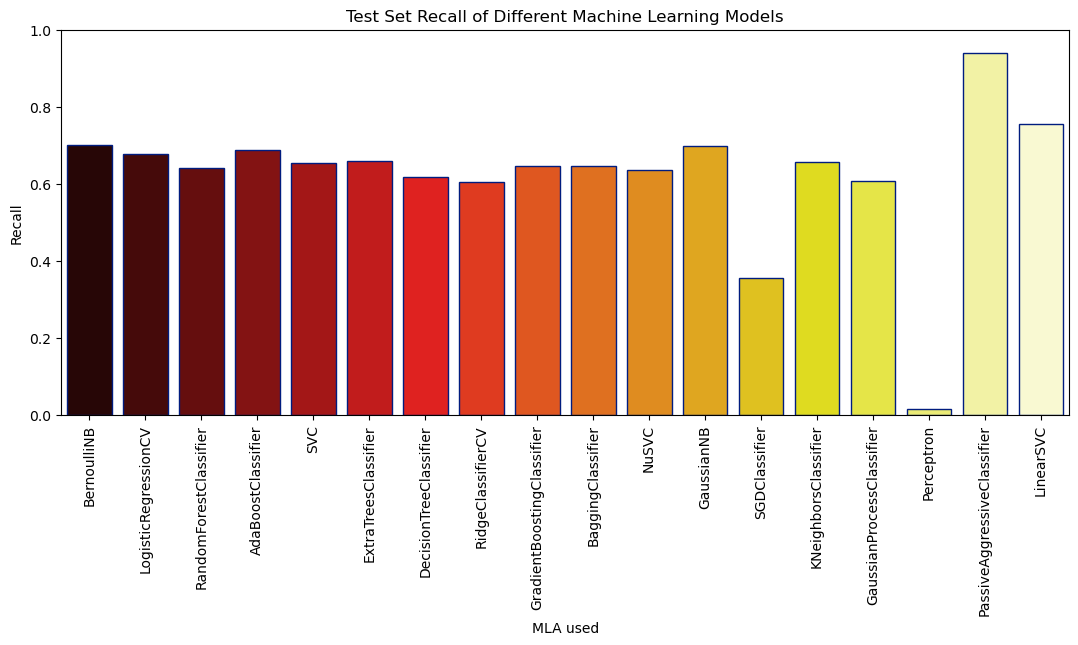

In [79]:
# Creating plots for MLA recall comparison
plt.subplots(figsize=(13,5))
sns.barplot(x="MLA used", y="Recall",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title('Test Set Recall of Different Machine Learning Models')
plt.savefig(date + '_algorithm_comparison_extra_recall.png', dpi = 300, bbox_inches = 'tight') 
plt.show()

# Naive Bayes Model

In [81]:
nb = naive_bayes.BernoulliNB()
nb.fit(X_train[features], y_train)

BernoulliNB()

In [82]:
nb_y_test_predict = nb.predict(validation_X[features])

In [83]:
get_stats(validation_y, nb_y_test_predict)

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,63.19,59.88,70.18,70.18,43.23,70.18,56.77,64.62,63.47,27.13


In [84]:
get_result_csv(validation_identifier_df, validation_X, validation_y, nb_y_test_predict, date + '_nb_classification_nonredundant', True)

,CYS_P_7.5,ASP_P_7.5,SER_P_7.5,GLN_P_7.5,LYS_P_7.5,ILE_P_7.5,PRO_P_7.5,THR_P_7.5,PHE_P_7.5,ASN_P_7.5,...,hbond_acc_sc_atom_5_7.5_P,hbond_don_bb_atom_5_7.5_P,hbond_acc_bb_atom_5_7.5_P,saas_P_7.5,index,identifier,ratio_mean,y_actual,y_predicted,correct
0,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,0.000000,...,2.000000,6.666667,2.666667,0.000000,0,O00255_C414_4OG4_C409,10.017634,0,1,0
1,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,9.523810,4.761905,...,2.580645,7.096774,4.516129,0.000000,1,O00255_C414_6BXH_C409,10.017634,0,1,0
2,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,9.523810,4.761905,...,3.225806,7.741935,2.580645,0.000000,2,O00255_C414_6O5I_C409,10.017634,0,1,0
3,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,5.000000,...,1.875000,7.500000,2.500000,0.000000,3,O00255_C414_6S2K_C411,10.017634,0,1,0
4,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,5.000000,...,3.184713,7.006369,3.821656,0.000000,4,O00255_C414_6WNH_C409,10.017634,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0.0,0.000000,5.555556,5.555556,16.666667,0.000000,0.000000,0.0,5.555556,0.000000,...,0.000000,6.547619,5.357143,2.222222,590,Q9Y6M9_C31_5XTC_C31,15.000000,0,1,0
591,0.0,7.692308,7.692308,0.000000,15.384615,15.384615,7.692308,0.0,0.000000,15.384615,...,2.777778,5.555556,2.777778,14.074074,591,Q9Y6N5_C127_6MO6_C127,15.400000,0,0,1
592,0.0,0.000000,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,0.000000,14.285714,...,2.836879,4.964539,3.546099,0.740741,592,Q9Y6N5_C127_6MP5_C127,15.400000,0,1,0
593,0.0,7.142857,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,0.000000,14.285714,...,4.316547,5.755396,2.877698,0.740741,593,Q9Y6N5_C127_6OIB_C127,15.400000,0,1,0


[[176 134]
 [ 85 200]]
['56.77%', '43.23%', '29.82%', '70.18%']


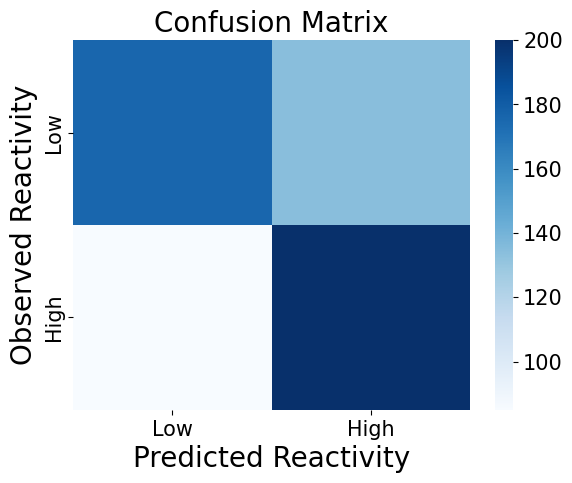

In [85]:
plot_cm_stats(0, date + '_nb_classification_nonredundant_', validation_y, nb_y_test_predict, False)

['56.77%', '43.23%', '29.82%', '70.18%']


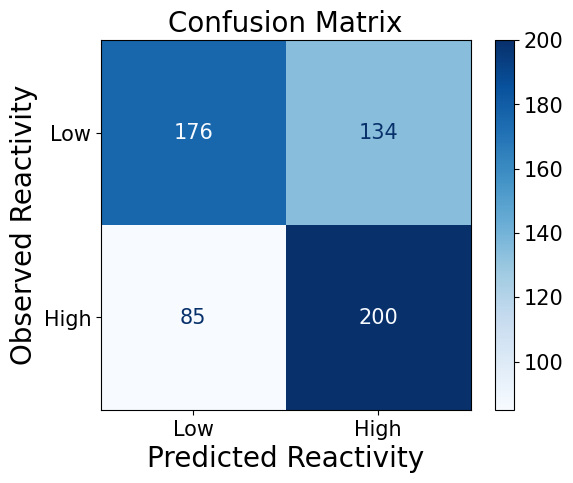

In [86]:
plot_cm_function_stats(0, date + '_nb_classification_nonredundant_', validation_y, nb_y_test_predict, False)

# 

# LRCV

In [89]:
lrcv =  linear_model.LogisticRegressionCV().fit(X_train[features], y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [90]:
y_test_lrcv_predict = lrcv.predict(validation_X[features])

In [91]:
get_stats(validation_y, y_test_lrcv_predict)

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,62.35,59.38,67.72,67.72,42.58,67.72,57.42,63.28,62.57,25.22


[[178 132]
 [ 92 193]]
['57.42%', '42.58%', '32.28%', '67.72%']


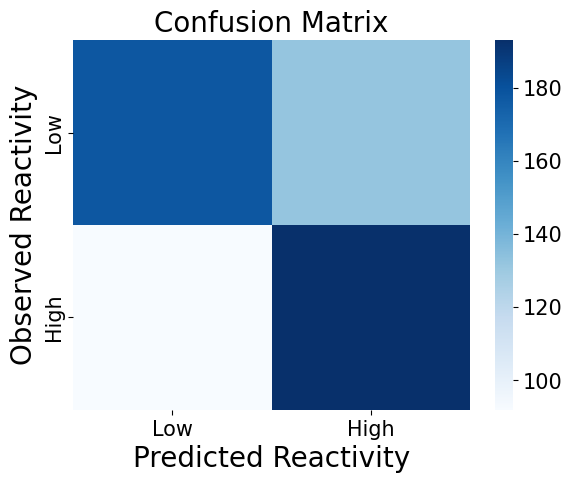

In [92]:
plot_cm_stats(0, date + '_lrcv_classification_nonredundant', validation_y, y_test_lrcv_predict, False)

['57.42%', '42.58%', '32.28%', '67.72%']


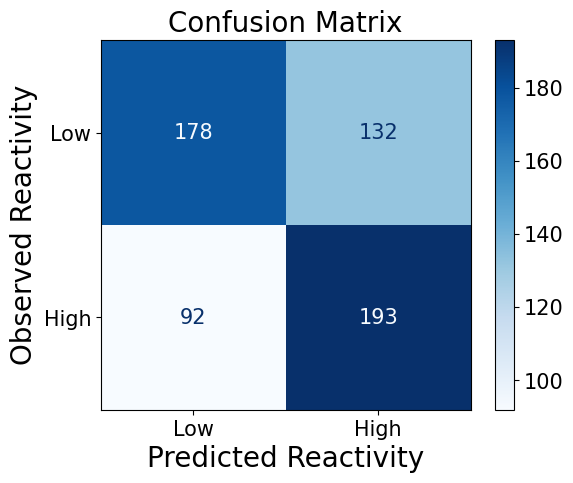

In [93]:
plot_cm_function_stats(0, date + '_lrcv_classification_nonredundant', validation_y, y_test_lrcv_predict, False)

# 

# Bagging

In [96]:
bg = ensemble.BaggingClassifier().fit(X_train[features], y_train)

In [97]:
bg_y_test_predict = bg.predict(validation_X[features])

In [98]:
get_stats(validation_y, bg_y_test_predict)

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,63.53,62.41,60.0,60.0,33.23,60.0,66.77,61.18,63.39,26.83


[[207 103]
 [114 171]]
['66.77%', '33.23%', '40.0%', '60.0%']


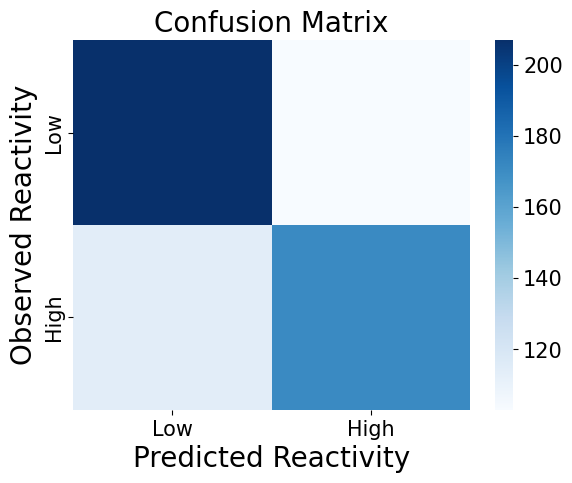

In [99]:
plot_cm_stats(0, date + '_bg_classification_nonredundant', validation_y, bg_y_test_predict, False)

['66.77%', '33.23%', '40.0%', '60.0%']


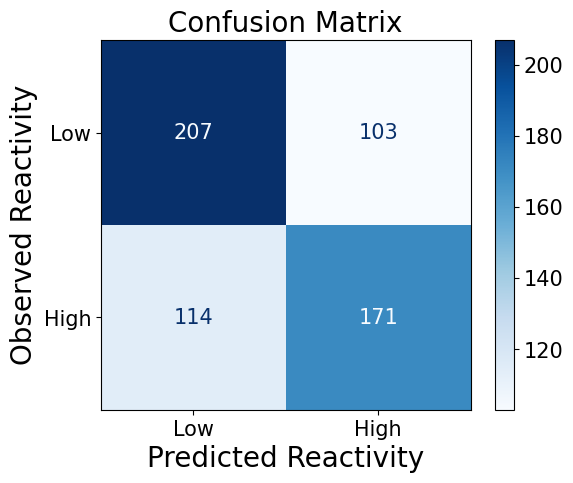

In [100]:
plot_cm_function_stats(0, date + '_bg_classification_nonredundant', validation_y, bg_y_test_predict, False)

# 

# Random Forest Model

In [103]:
rf = RandomForestClassifier(random_state=42).fit(X_train[features], y_train)

In [104]:
y_test_rf_predict = rf.predict(validation_X[features])

In [105]:
get_stats(validation_y, y_test_rf_predict)

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,65.88,62.73,70.88,70.88,38.71,70.88,61.29,66.56,66.08,32.25


In [106]:
get_result_csv(validation_identifier_df, validation_X, validation_y, y_test_rf_predict, date + '_rf_classification_nonredundant', True)

,CYS_P_7.5,ASP_P_7.5,SER_P_7.5,GLN_P_7.5,LYS_P_7.5,ILE_P_7.5,PRO_P_7.5,THR_P_7.5,PHE_P_7.5,ASN_P_7.5,...,hbond_acc_sc_atom_5_7.5_P,hbond_don_bb_atom_5_7.5_P,hbond_acc_bb_atom_5_7.5_P,saas_P_7.5,index,identifier,ratio_mean,y_actual,y_predicted,correct
0,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,0.000000,...,2.000000,6.666667,2.666667,0.000000,0,O00255_C414_4OG4_C409,10.017634,0,1,0
1,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,9.523810,4.761905,...,2.580645,7.096774,4.516129,0.000000,1,O00255_C414_6BXH_C409,10.017634,0,1,0
2,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,9.523810,4.761905,...,3.225806,7.741935,2.580645,0.000000,2,O00255_C414_6O5I_C409,10.017634,0,1,0
3,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,5.000000,...,1.875000,7.500000,2.500000,0.000000,3,O00255_C414_6S2K_C411,10.017634,0,1,0
4,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,5.000000,...,3.184713,7.006369,3.821656,0.000000,4,O00255_C414_6WNH_C409,10.017634,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0.0,0.000000,5.555556,5.555556,16.666667,0.000000,0.000000,0.0,5.555556,0.000000,...,0.000000,6.547619,5.357143,2.222222,590,Q9Y6M9_C31_5XTC_C31,15.000000,0,0,1
591,0.0,7.692308,7.692308,0.000000,15.384615,15.384615,7.692308,0.0,0.000000,15.384615,...,2.777778,5.555556,2.777778,14.074074,591,Q9Y6N5_C127_6MO6_C127,15.400000,0,0,1
592,0.0,0.000000,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,0.000000,14.285714,...,2.836879,4.964539,3.546099,0.740741,592,Q9Y6N5_C127_6MP5_C127,15.400000,0,0,1
593,0.0,7.142857,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,0.000000,14.285714,...,4.316547,5.755396,2.877698,0.740741,593,Q9Y6N5_C127_6OIB_C127,15.400000,0,0,1


## Confusion Matrices

[[190 120]
 [ 83 202]]
['61.29%', '38.71%', '29.12%', '70.88%']


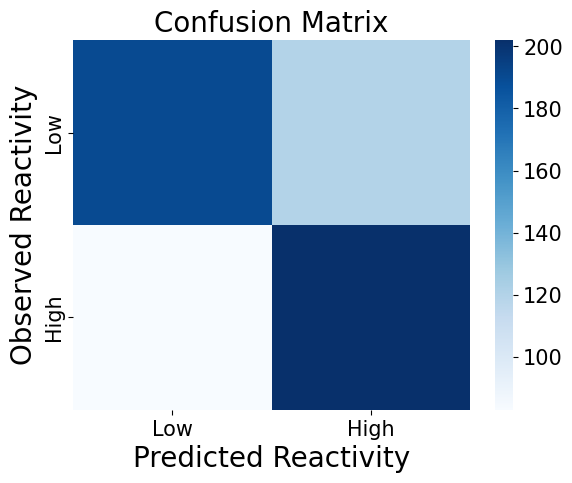

In [108]:
plot_cm_stats(0, date + '_rf_classification_nonredundant', validation_y, y_test_rf_predict, False)

['61.29%', '38.71%', '29.12%', '70.88%']


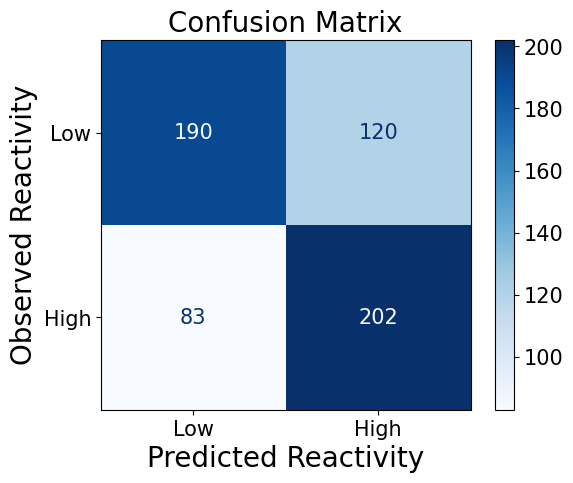

In [109]:
plot_cm_function_stats(0, date + '_rf_classification_nonredundant', validation_y, y_test_rf_predict, False)

## Classification Report

In [111]:
sampleClassificationReport = classification_report(validation_y, y_test_rf_predict,
                                                  target_names=["High", 'Low'])

In [112]:
print(sampleClassificationReport)

              precision    recall  f1-score   support

        High       0.70      0.61      0.65       310
         Low       0.63      0.71      0.67       285

    accuracy                           0.66       595
   macro avg       0.66      0.66      0.66       595
weighted avg       0.66      0.66      0.66       595



### Random Forest based model minimizes the FPR. Therefore, we will continue with the RF algorithm.

## Feature Importances

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/2600685120.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feat_coeff.features, x=feat_coeff.impacts, ax=ax1, orient = "h", palette = 'Blues_r');


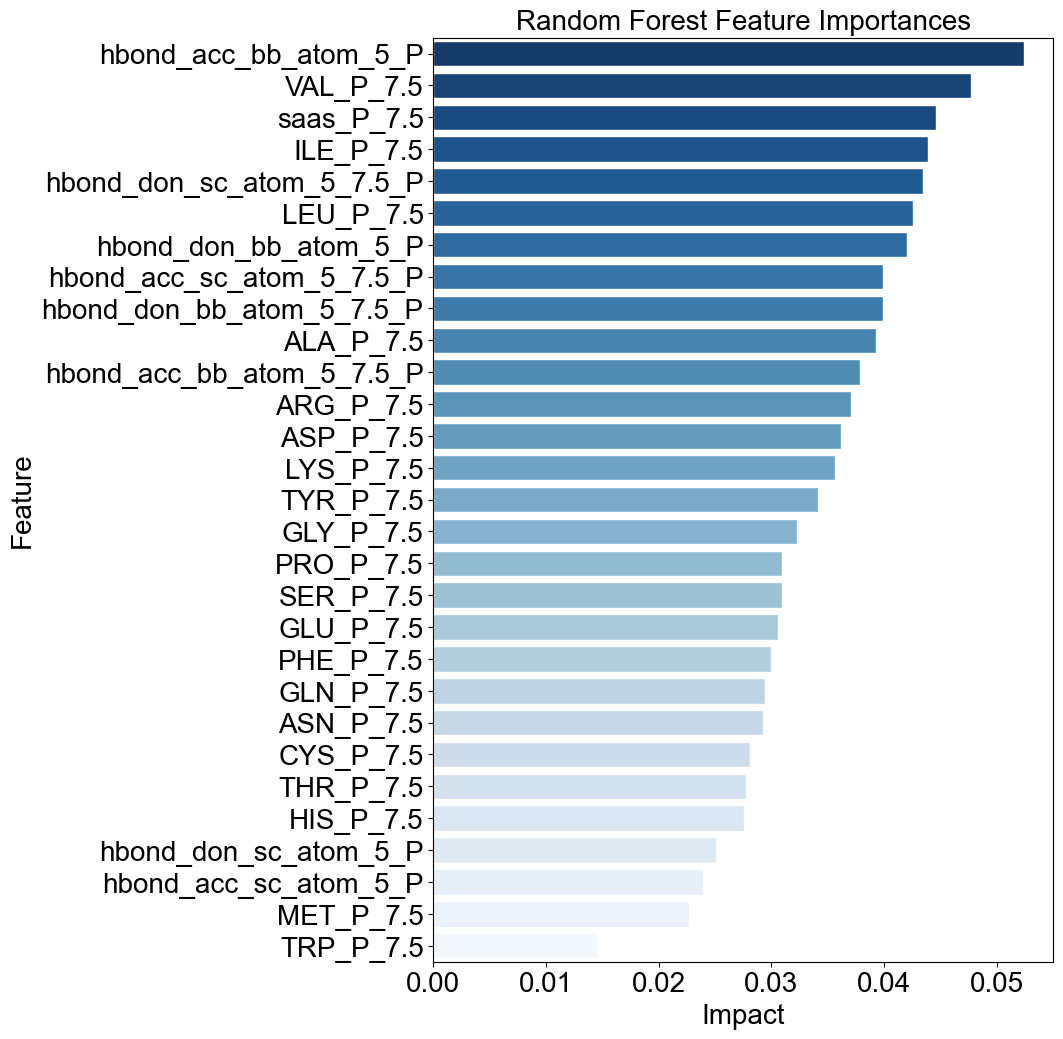

In [115]:
get_horizontal_feature_importances(X_train, rf, date + '_rf_classifier_base_model_nonredundant', False, False)

## Shapley Plot

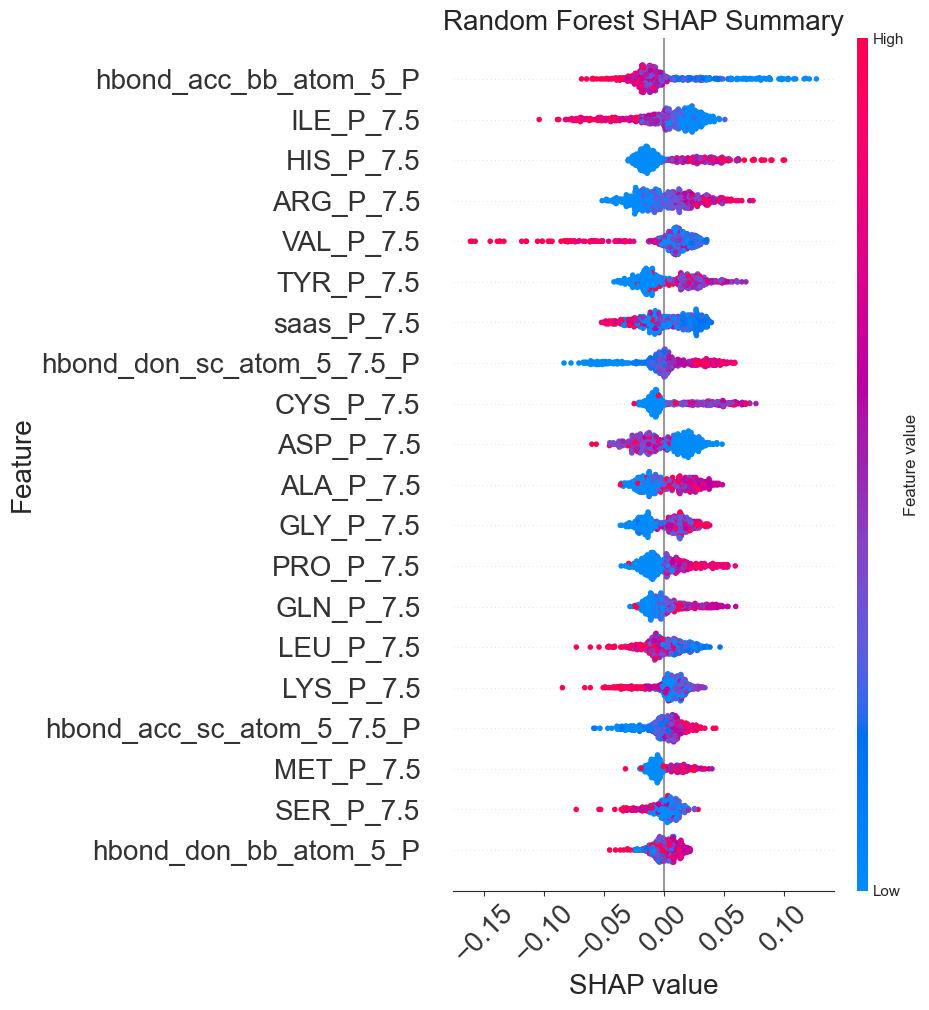

In [117]:
get_shap_plot(validation_X, rf, date + '_rf_classifier_base_model_nonredundant', False)

### An increased number of hydrogen bond donor side chain atoms 5-7.5 Angstroms away, histidine residues, arginine residues and proline residues (towards highly reactive cysteines) values contribute positively towards our hyperreactivity predictions. While a decreased number of hydrogen bond acceptor backbone atoms 5 Angstroms away, isoleucine residues, valine residues, and relative solvent accessibility values also contribute positively towards our hyperreactivity predictions.   

# 

# Cross-Validation on the Training Set

In [121]:
def perform_cv(X_train, y_train, X_test, y_test, features, model):
    from sklearn.model_selection import KFold, cross_val_score

    # Define the model (same as the one you used)
    rf = RandomForestClassifier(random_state=42)

    # Set up K-fold cross-validation (e.g., 5 folds)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation on the training data using the same feature set
    cv_scores = cross_val_score(rf, X_train[features], y_train, cv=kf, scoring='accuracy')

    # Print the cross-validation results
    print("Cross-validation scores on training set:", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())

    # Once satisfied with the cross-validation results, train the model on the full training set
    model.fit(X_train, y_train)

    # Test the model on your external test set
    test_score = model.score(X_test, y_test)
    print("Test set score:", test_score)

In [122]:
perform_cv(X_train, y_train, validation_X.drop(columns = ['index']), validation_y, features, rf)

Cross-validation scores on training set: [0.8540146  0.77372263 0.82116788 0.7919708  0.80656934]
Average cross-validation score: 0.8094890510948906
Test set score: 0.6588235294117647


# Repeated K-Fold Cross-Validation on the Training Set

In [124]:
def perform_stratkfold(X_train, y_train, X_test, y_test, features, model): 
    from sklearn.model_selection import RepeatedKFold

    # Set up Repeated K-Fold cross-validation (5 folds, repeated 3 times)
    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    # Perform repeated cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring='accuracy')

    # Print the repeated cross-validation results
    print("Repeated K-Fold cross-validation scores on training set:", cv_scores)
    print("Average score across repeated folds:", cv_scores.mean())

    # Train on full training set and evaluate on test set
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("Test set score:", test_score)

In [125]:
perform_stratkfold(X_train, y_train, validation_X.drop(columns = ['index']), validation_y, features, rf)

Repeated K-Fold cross-validation scores on training set: [0.8540146  0.77372263 0.82116788 0.7919708  0.80656934 0.81751825
 0.79562044 0.78832117 0.82481752 0.85036496 0.84671533 0.81751825
 0.84671533 0.81751825 0.83211679]
Average score across repeated folds: 0.8189781021897812
Test set score: 0.6588235294117647


# Repeated Test Set Sampling 

In [127]:
def run_sampling(X_train, y_train, validation_ml_df):
    n_iterations = 5  # Number of times to repeat sampling
    test_scores = []
    
    # get X and y values
    X_test = validation_ml_df.drop('reactivity', axis = 1)
    y_test = validation_ml_df['reactivity']

     
    rf = RandomForestClassifier(random_state=42).fit(X_train[features], y_train)
    # Train the model on the full training set
    rf.fit(X_train[features], y_train)
    
    y_test_predict = rf.predict(X_test[features])
    
    print(get_stats(y_test, y_test_predict))


In [128]:
run_sampling(X_train, y_train, validation_df)

   Accuracy  Precision  Recall    TPR    FPR  Sensitivity  Specificity     F1  \
0     65.88      62.73   70.88  70.88  38.71        70.88        61.29  66.56   

     AUC    MCC  
0  66.08  32.25  


## ROC Curve

In [130]:
def get_5_cv_balanced_roc_curve(name, ml_df, validation_ml_df, X_vals, y_vals, save):
    
    validation_ml_df =validation_ml_df.drop(columns = ['uniprot_identifier'])

    clf = RandomForestClassifier(random_state = 42)

    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []
    
    for i in range(5):
    
        df_train_percent = ml_df.sample(frac=0.8)
    
        # get X and y values
        current_X_train = df_train_percent.drop(['reactivity'], axis = 1)
        current_y_train = df_train_percent['reactivity']

        df_test_percent = validation_ml_df.sample(frac=0.8)
    
        # get X and y values
        current_X_test = df_test_percent.drop('reactivity', axis = 1)
        current_y_test = df_test_percent['reactivity']

        clf.fit(current_X_train, current_y_train)
        y_predict = clf.predict(current_X_test)
        fpr, tpr, thresholds = roc_curve(current_y_test, y_predict)
        auc_score = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs, name, save)

0.6598793363499246
0.5981105036887638
0.5964781746031746
0.643583945732052
0.631858407079646


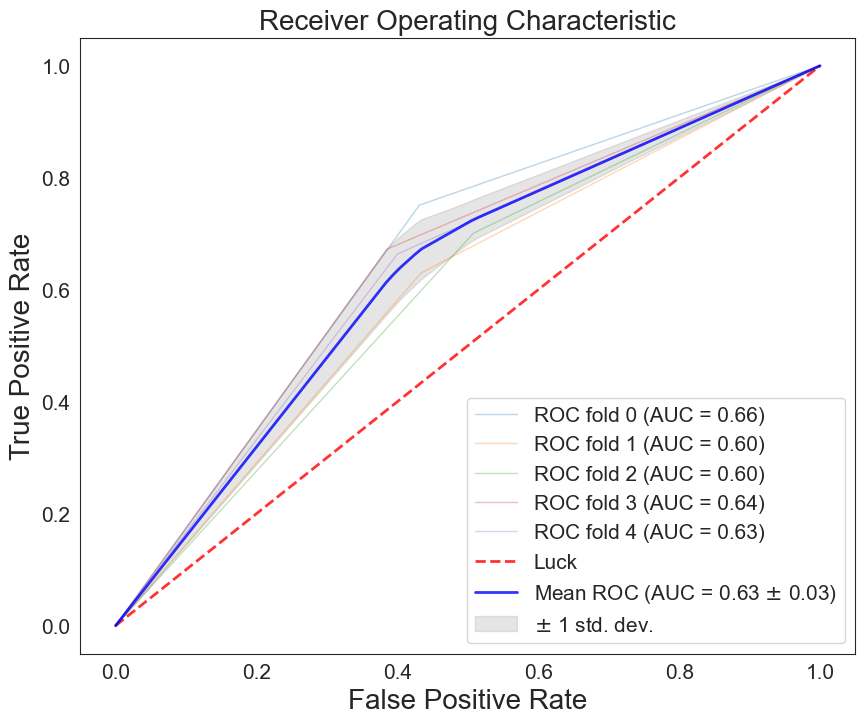

In [131]:
get_5_cv_balanced_roc_curve('roc_balanced_rf', ml_df, validation_ml_df, [], [], False)

# 

# Optimization

## Grid Search CV on Training Set

In [135]:
rfc_grid = RandomForestClassifier(random_state = 42)
param_grid = {
    'n_estimators': [5, 100, 150, 200],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']}


grid_search = GridSearchCV(rfc_grid, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 150}


In [136]:
# manually input best hyper parameters
gridcv_rfc = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 6, 
                                 max_features = 'log2', n_estimators = 150)
gridcv_rfc.fit(X_train, y_train)
gridcv_y_pred = gridcv_rfc.predict(validation_X.drop(columns = ['index']))

In [137]:
# model performance with hyperparameter tuning
get_stats(validation_y, gridcv_y_pred)

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,64.03,60.29,72.98,72.98,44.19,72.98,55.81,66.03,64.39,29.14


[[173 137]
 [ 77 208]]
['55.81%', '44.19%', '27.02%', '72.98%']


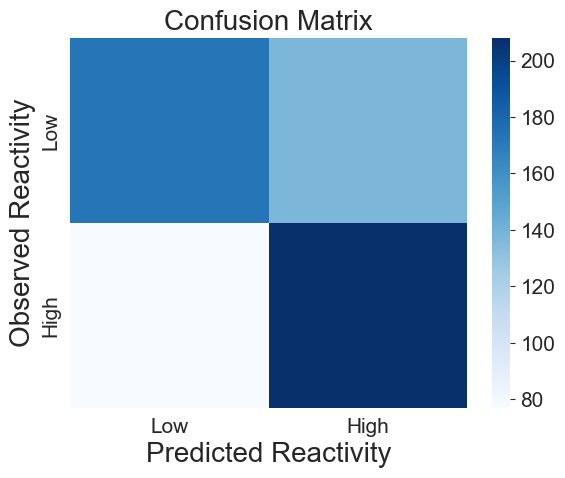

In [138]:
plot_cm_stats(0, date + '_rf_classification_nonredundant_grid_search', validation_y, gridcv_y_pred, False)

['55.81%', '44.19%', '27.02%', '72.98%']


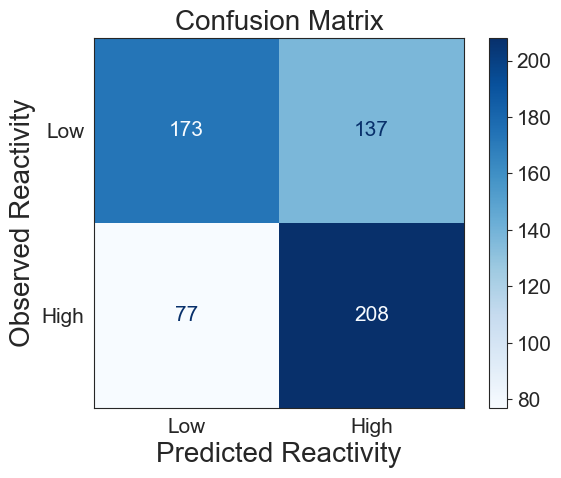

In [139]:
plot_cm_function_stats(0, date + '_rf_classification_nonredundant_grid_search', validation_y, gridcv_y_pred, False)

### The model performance decreases and FPR increases when predicting the test set data with hyperparameter tuning. The GridSearch CV could have overfit the training data, thus leading to less accurate predictions for the test set. 

# 

# Recursive Feature Elimination

In [143]:
min_features_to_select = 2
rfe_rfc = RandomForestClassifier(random_state = 42)

rfecv = RFECV(
    estimator=rfe_rfc,
    step=1,
    cv=5,
    scoring="accuracy",
    min_features_to_select=min_features_to_select
)

rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=42),
      min_features_to_select=2, scoring='accuracy')

In [144]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 29


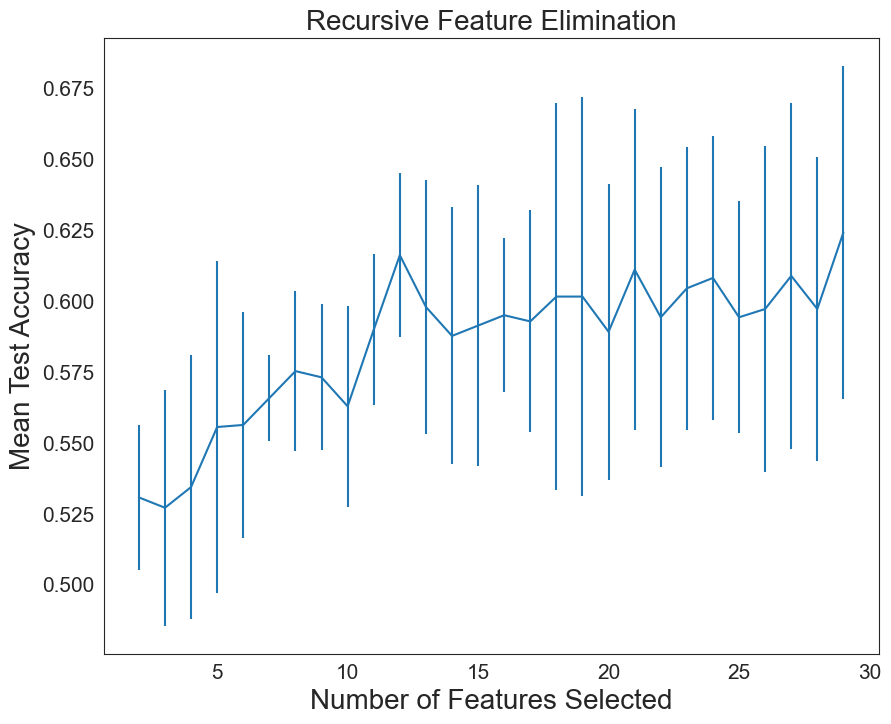

In [145]:
get_rfe_plot(rfecv, 'base_rf_auc', True)

In [146]:
rfe_features_df, chosen_rfe_features_df, chosen_ids, not_chosen_ids = get_rfe_df(rfecv, X_train)
rfe_features_df.sort_values('Ranking', ascending=True)

,Feature,Support,Ranking
0,CYS_P_7.5,True,1
26,hbond_don_bb_atom_5_7.5_P,True,1
25,hbond_acc_sc_atom_5_7.5_P,True,1
24,hbond_don_sc_atom_5_7.5_P,True,1
23,hbond_acc_bb_atom_5_P,True,1
22,hbond_don_bb_atom_5_P,True,1
21,hbond_acc_sc_atom_5_P,True,1
20,hbond_don_sc_atom_5_P,True,1
19,MET_P_7.5,True,1
18,TYR_P_7.5,True,1


## Reduced Feature Model using the most "optimal" features selected

In [148]:
def get_rfe_model(chosen_ids, lof_train_df, lof_test_df):
    rfe_X_train = lof_train_df[chosen_ids]
    rfe_y_train = lof_train_df['reactivity']

    rfe_X_test = lof_test_df[chosen_ids]
    rfe_y_test = lof_test_df['reactivity']
    
    rfe_rfc = RandomForestClassifier(random_state = 42)
    rfe_rfc.fit(rfe_X_train, rfe_y_train)
    rfe_y_pred = rfe_rfc.predict(rfe_X_test)
    
    return rfe_X_train, rfe_y_test, rfe_y_test, rfe_y_pred

In [149]:
rfe_X_train = lof_train_df[chosen_ids]
rfe_y_train = lof_train_df['reactivity']

rfe_X_test = lof_test_df[chosen_ids]
rfe_y_test = lof_test_df['reactivity']

In [150]:
rfe_rfc = RandomForestClassifier(random_state = 42)
rfe_rfc.fit(rfe_X_train, rfe_y_train)
rfe_y_pred = rfe_rfc.predict(rfe_X_test)

In [151]:
# model performance with reduced features
get_stats(rfe_y_test, rfe_y_pred)

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,65.88,62.73,70.88,70.88,38.71,70.88,61.29,66.56,66.08,32.25


In [152]:
get_result_csv(validation_identifier_df, rfe_X_test, rfe_y_test, rfe_y_pred, date + '_rfe_rf_classification_nonredundant', True)

,CYS_P_7.5,ASP_P_7.5,SER_P_7.5,GLN_P_7.5,LYS_P_7.5,ILE_P_7.5,PRO_P_7.5,THR_P_7.5,PHE_P_7.5,ASN_P_7.5,...,hbond_acc_sc_atom_5_7.5_P,hbond_don_bb_atom_5_7.5_P,hbond_acc_bb_atom_5_7.5_P,saas_P_7.5,index,identifier,ratio_mean,y_actual,y_predicted,correct
0,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,0.000000,...,2.000000,6.666667,2.666667,0.000000,0,O00255_C414_4OG4_C409,10.017634,0,1,0
1,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,9.523810,4.761905,...,2.580645,7.096774,4.516129,0.000000,1,O00255_C414_6BXH_C409,10.017634,0,1,0
2,0.0,4.761905,4.761905,9.523810,0.000000,0.000000,4.761905,0.0,9.523810,4.761905,...,3.225806,7.741935,2.580645,0.000000,2,O00255_C414_6O5I_C409,10.017634,0,1,0
3,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,5.000000,...,1.875000,7.500000,2.500000,0.000000,3,O00255_C414_6S2K_C411,10.017634,0,1,0
4,0.0,5.000000,5.000000,10.000000,0.000000,0.000000,5.000000,0.0,10.000000,5.000000,...,3.184713,7.006369,3.821656,0.000000,4,O00255_C414_6WNH_C409,10.017634,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0.0,0.000000,5.555556,5.555556,16.666667,0.000000,0.000000,0.0,5.555556,0.000000,...,0.000000,6.547619,5.357143,2.222222,590,Q9Y6M9_C31_5XTC_C31,15.000000,0,0,1
591,0.0,7.692308,7.692308,0.000000,15.384615,15.384615,7.692308,0.0,0.000000,15.384615,...,2.777778,5.555556,2.777778,14.074074,591,Q9Y6N5_C127_6MO6_C127,15.400000,0,0,1
592,0.0,0.000000,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,0.000000,14.285714,...,2.836879,4.964539,3.546099,0.740741,592,Q9Y6N5_C127_6MP5_C127,15.400000,0,0,1
593,0.0,7.142857,7.142857,0.000000,14.285714,14.285714,7.142857,0.0,0.000000,14.285714,...,4.316547,5.755396,2.877698,0.740741,593,Q9Y6N5_C127_6OIB_C127,15.400000,0,0,1


In [153]:
cm = confusion_matrix(rfe_y_test, rfe_y_pred)
print(cm)

[[190 120]
 [ 83 202]]


[[190 120]
 [ 83 202]]
['61.29%', '38.71%', '29.12%', '70.88%']


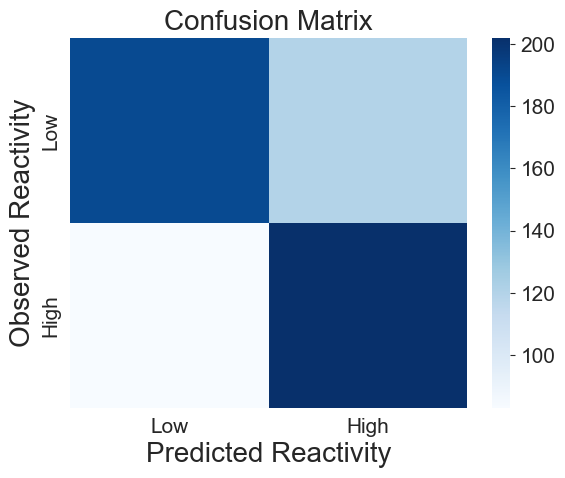

In [154]:
plot_cm_stats(0, date + '_rfe_rf_classification_nonredundant_', rfe_y_test, rfe_y_pred, False)

['61.29%', '38.71%', '29.12%', '70.88%']


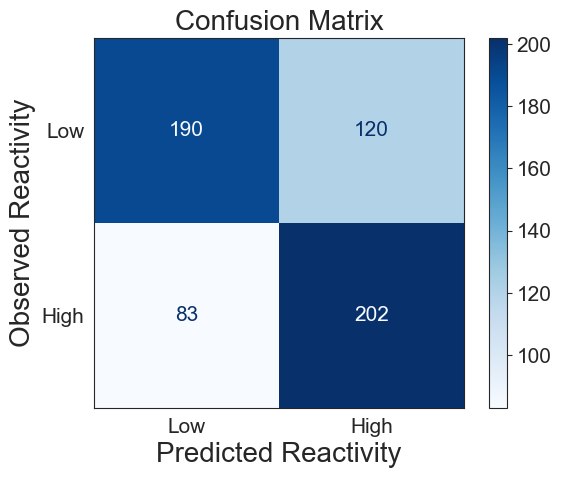

In [155]:
plot_cm_function_stats(0, date + '_rfe_rf_classification_nonredundant_', rfe_y_test, rfe_y_pred, True)

/var/folders/4c/kr7lv7195d92x2l4kyj4r3z00000gn/T/ipykernel_56522/2600685120.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feat_coeff.features, x=feat_coeff.impacts, ax=ax1, orient = "h", palette = 'Blues_r');


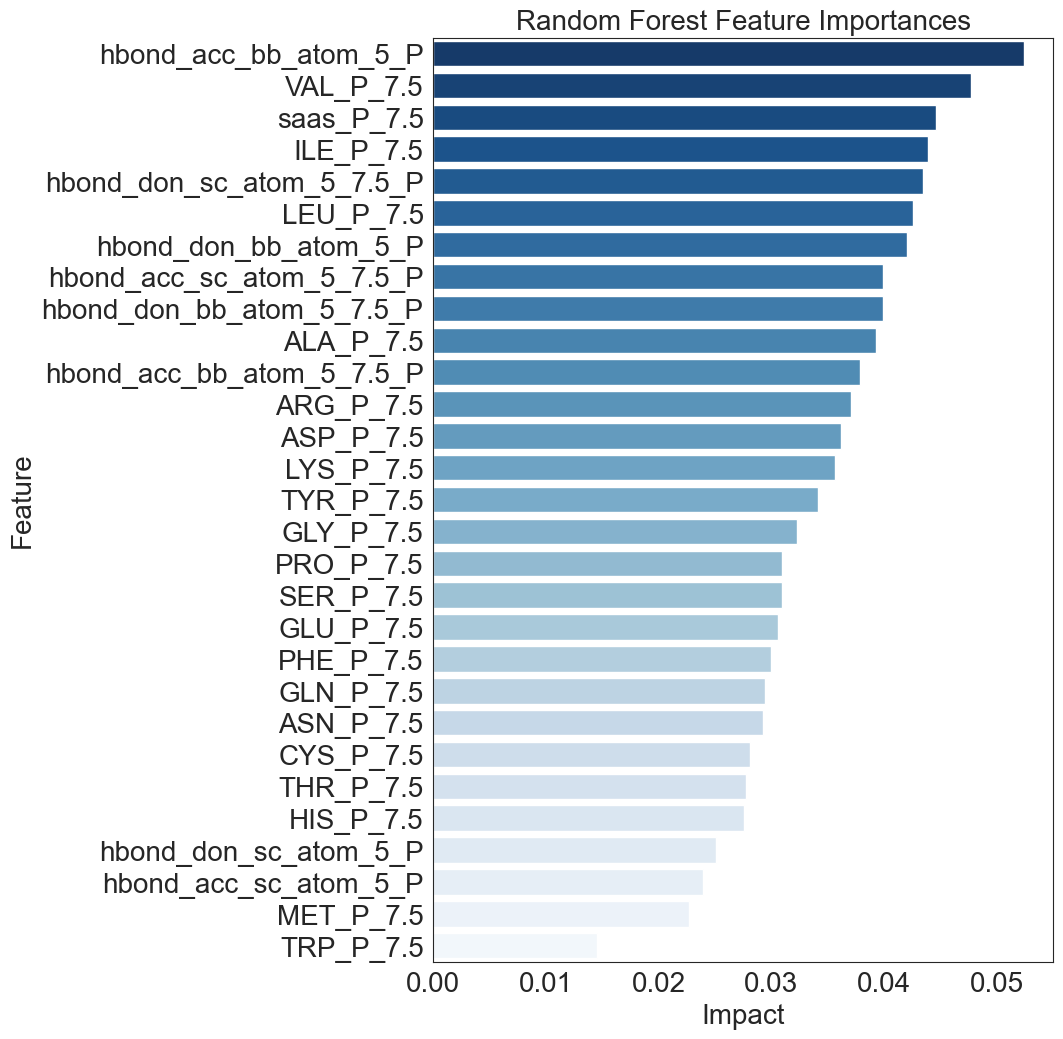

In [156]:
get_horizontal_feature_importances(rfe_X_train, rfe_rfc, date + '_rfe_rf_classifier_base_model_nonredundant', False, False)

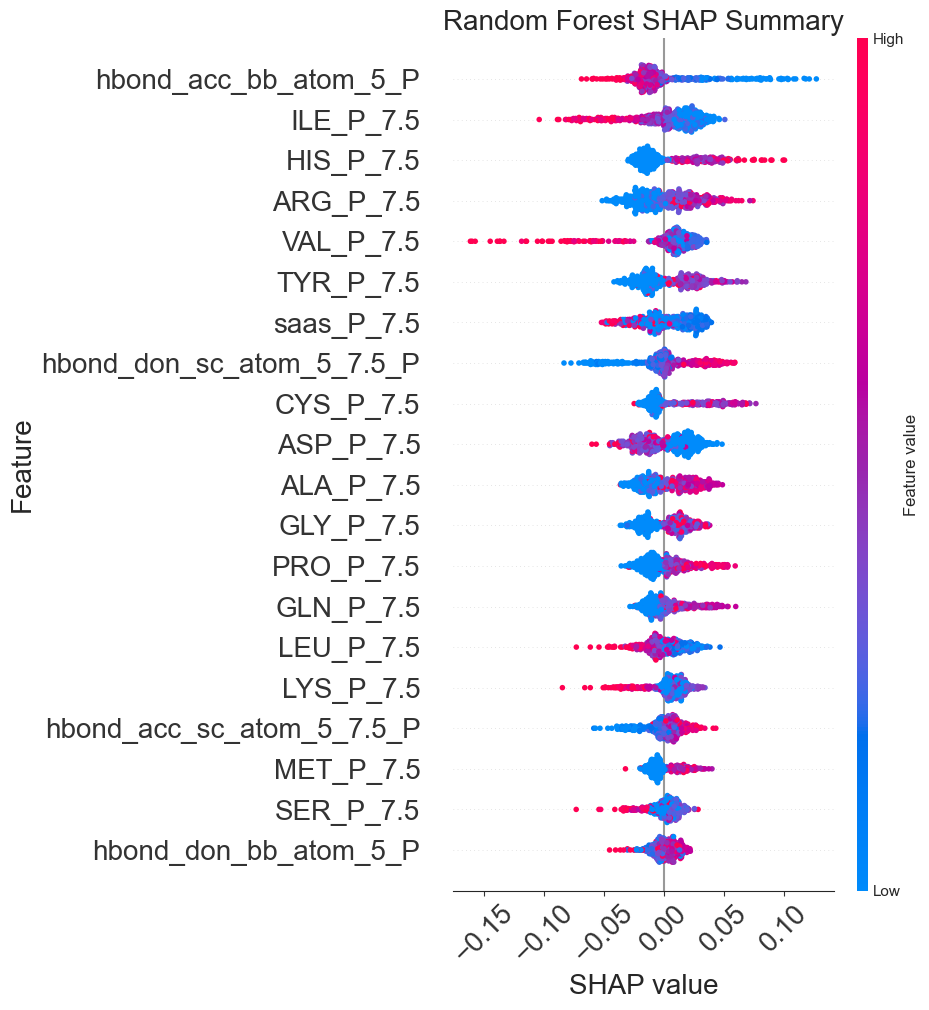

In [157]:
get_shap_plot(rfe_X_test, rfe_rfc, date + '_rfe_rfc_classifier_base_model_nonredundant', False)

### The model perfomance has remained the same after performing RFE, as 29 out of 29 features were included. Therefore, we will continue forth with using the random forest model with all the features.

# 

# Save CIAA RF Model

In [161]:
model_pkl_file = "ciaa_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(rfe_rfc, file)

# 

# Additional Validation Sets

In [268]:
def get_modified_target(df, cutoff):
    
    target_vals = []
    
    for index, row in df.iterrows():
        if float(row['ratio_mean']) <= cutoff:
            target_vals.append(1)
        else:
            target_vals.append(0)
            
    df['reactivity'] = target_vals
    return df

In [274]:
def test_validation_set(validation_df, chosen_ids, rfe_rfc, af, dataset, save):
    validation_ml_df = validation_df.drop(columns = ['reactivity'])
    validation_ml_df = get_modified_target(validation_ml_df, 3)
    validation_identifier_df, validation_ml_df = get_identifier_df(validation_ml_df)
    
    validation_ml_df = validation_ml_df[chosen_ids + ['reactivity']]
    validation_ml_df = validation_ml_df[validation_ml_df['reactivity'] != 0.5]
    
    validation_X = validation_ml_df.drop('reactivity', axis = 1)
    validation_y = validation_ml_df['reactivity']

    validation_y_pred = rfe_rfc.predict(validation_X)
    
    stat_df = get_stats(validation_y, validation_y_pred)

    validation_csv_df = get_result_csv(validation_identifier_df, validation_X, list(validation_y), validation_y_pred, date + '_' + dataset + '_prediction_results', True)

    return validation_X, validation_y, validation_y_pred, validation_ml_df, stat_df

# 

# Case 1: Proteins with correct predictions based on PDB structures and now using descriptors based on AlphaFold structures

In [347]:
af_df = pd.read_csv('../../data/isotop_alphafold_pdb_set.csv')

In [349]:
af_validation_X, af_validation_y, af_validation_y_pred, af_validation_identifier_df, af_stat_df = test_validation_set(af_df, features, rfe_rfc, False, 'reactivity_alphafold', rfe_X_train)

In [351]:
af_stat_df

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,72.46,73.33,75.0,75.0,30.38,75.0,69.62,74.16,72.31,44.69


[[55 24]
 [22 66]]
['69.62%', '30.38%', '25.0%', '75.0%']


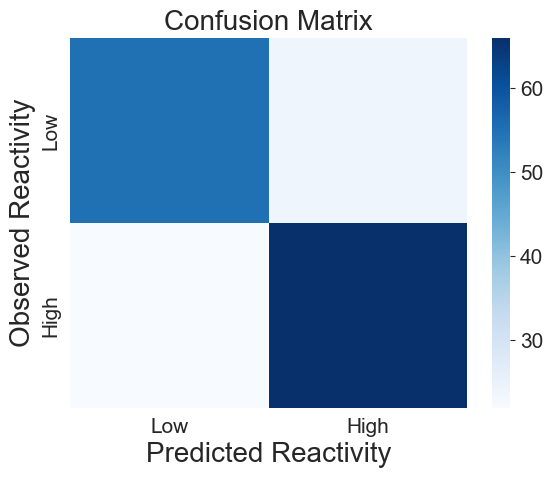

In [353]:
plot_cm_stats(0, '_rf_classifier_af', af_validation_y, af_validation_y_pred, False)

['69.62%', '30.38%', '25.0%', '75.0%']


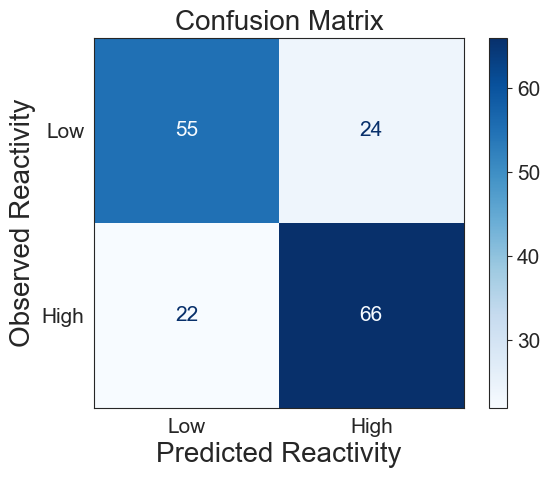

In [355]:
plot_cm_function_stats(0, date + '_rf_classifier_af', af_validation_y, af_validation_y_pred, True)

# 

# Case 2: Proteins we have experimentally determined reactivity ratios, but these proteins do not have the associated cysteine resolved in their PDB or these proteins do not have an associated PDB.

In [359]:
af_denovo_df = pd.read_csv('../../data/isotop_alphafold_denovo_set.csv')

In [361]:
af_denovo_df

,identifier,ratio_mean,reactivity,b_factor,disorder,atom_count_7.5,neighbor_count_7.5,net_charge_7.5,hydrophobicity_kd_7.5,steric_count_7.5,...,hbond_lr_bb,hbond_bb_sc,hbond_sc,dslf_fa13,omega,fa_dun,p_aa_pp,yhh_planarity,rama_prepro,score
0,O95336_C32,1.319985,High,96.63,0,34,8,1,0.412500,0,...,0.000,0.0,0.0,0.0,-0.003,1.025,0.262,0,0.172,2.510
1,Q8NEC7_C140,1.055379,High,89.42,0,56,14,-1,-0.128571,0,...,0.000,0.0,0.0,0.0,0.090,0.735,0.304,0,-0.344,-0.460
2,Q9H479_C24,1.496780,High,65.83,0,24,5,0,1.560000,0,...,0.000,0.0,0.0,0.0,0.650,0.347,0.316,0,-0.022,4.315
3,Q66K14_C289,1.025842,High,86.35,0,36,9,1,-1.222222,0,...,0.000,0.0,0.0,0.0,0.190,1.098,0.254,0,0.233,2.167
4,O14654_C332,2.225066,High,83.18,0,73,16,2,0.162500,1,...,0.000,0.0,0.0,0.0,0.208,0.287,0.294,0,-0.067,0.664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Q29RF7_C242,14.246000,Low,94.32,0,54,13,-2,0.984615,0,...,0.000,0.0,0.0,0.0,0.285,1.442,0.283,0,-0.001,1.118
503,Q2T9J0_C240,2.015000,High,93.26,0,35,10,1,1.270000,0,...,0.000,0.0,0.0,0.0,0.053,2.469,0.068,0,0.140,4.094
504,Q2T9J0_C284,1.114000,High,88.93,0,89,21,1,1.552381,0,...,-0.654,0.0,0.0,0.0,-0.028,0.434,0.157,0,0.255,-2.245
505,Q96NY7_C487,2.106667,High,85.55,0,61,11,1,-0.518182,0,...,0.000,0.0,0.0,0.0,-0.059,0.175,0.101,0,0.240,2.136


In [363]:
af_denovo_validation_X, af_denovo_validation_y, af_denovo_validation_y_pred, af_denovo_validation_identifier_df, af_denovo_stat_df = test_validation_set(af_denovo_df, features, rfe_rfc, False, 'reactivity_denovo', rfe_X_train)

In [365]:
af_denovo_stat_df

,Accuracy,Precision,Recall,TPR,FPR,Sensitivity,Specificity,F1,AUC,MCC
0,54.83,56.93,44.75,44.75,34.8,44.75,65.2,50.11,54.97,10.16


[[163  87]
 [142 115]]
['65.2%', '34.8%', '55.25%', '44.75%']


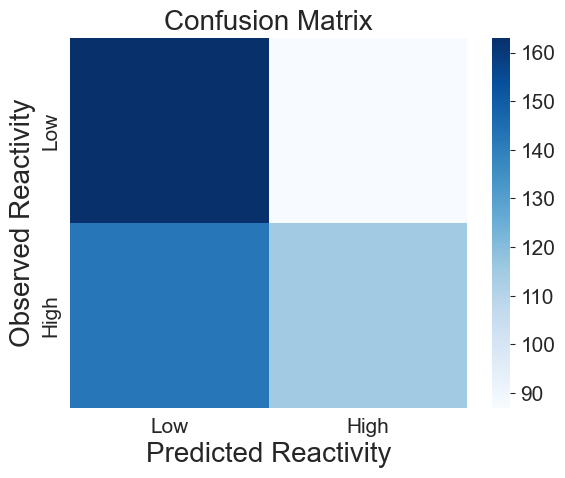

In [367]:
plot_cm_stats(0, '_rf_classifier_af_dn', af_denovo_validation_y, af_denovo_validation_y_pred, False)

['65.2%', '34.8%', '55.25%', '44.75%']


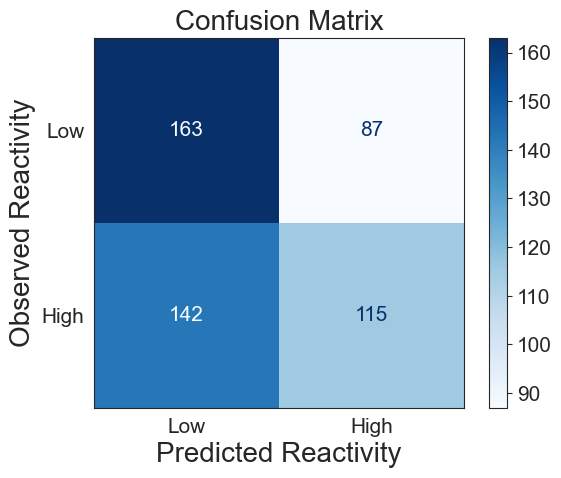

In [372]:
plot_cm_function_stats(0, date + '_rf_classifier_af_dn', af_denovo_validation_y, af_denovo_validation_y_pred, True)

# 